In [157]:
import pandas as pd
import requests
import urllib
import json
from urllib.parse import urlencode
import numpy as np
import calendar
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import squarify
from datetime import datetime, timedelta

In [2]:
def load_file_in_yandex(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = public_key
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    h = json.loads(response.text)['href'] # 'парсинг' ссылки на скачивание
    
    return h

In [3]:
#Загружаем таблицу с уникальными идентификаторами пользователей
olist_customers = pd.read_csv(load_file_in_yandex('https://disk.yandex.ru/d/FUi5uSd6BfG_ig'), 
                              sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

 **olist_customers_datase.csv** — таблица с уникальными идентификаторами пользователей
- `customer_id` — позаказный идентификатор пользователя
- `customer_unique_id` —  уникальный идентификатор пользователя  (в идеальных данных не может быть двух пользователей с одинаковым значением, является уникальным айдишником пользователя)
- `customer_zip_code_prefix` —  почтовый индекс пользователя
- `customer_city` —  город доставки пользователя
- `customer_state` —  штат доставки пользователя

In [4]:
olist_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
#Загружаем таблицу заказов
olist_orders = pd.read_csv(load_file_in_yandex('https://disk.yandex.ru/d/t9Li4JOfgxuUrg'), 
                           sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

**olist_orders_dataset.csv** —  таблица заказов
- `order_id` —  уникальный идентификатор заказа (номер чека)
- `customer_id` —  позаказный идентификатор пользователя
- `order_status` —  статус заказа:
        created —  создан
        approved —  подтверждён
        invoiced —  выставлен счёт
        processing —  в процессе сборки заказа
        shipped —  отгружен со склада
        delivered—  доставлен пользователю
        unavailable —  недоступен
        canceled —  отменён
- `order_purchase_timestamp` —  время создания заказа
- `order_approved_at` —  время подтверждения оплаты заказа
- `order_delivered_carrier_date` —  время передачи заказа в логистическую службу
- `order_delivered_customer_date` —  время доставки заказа
- `order_estimated_delivery_date` —  обещанная дата доставки

In [6]:
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
#Загружаем товарные позиции, входящие в заказы
olist_order_items = pd.read_csv(load_file_in_yandex('https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'), 
                           sep=',', error_bad_lines=False, comment='#' , encoding='cp1251')

**olist_order_items_dataset.csv** —  товарные позиции, входящие в заказы
- `order_id` —  уникальный идентификатор заказа (номер чека)
- `order_item_id` —  идентификатор товара внутри одного заказа (не содержит информацию о количестве товаров)
- `product_id` —  уникальный идентефикатор товара (аналог штрихкода)
- `seller_id` — уникальный идентефикатор производителя товара
- `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- `price` —  цена за единицу товара
- `freight_value` —  вес товара

In [8]:
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
# Объединяем таблицу заказов с таблицей с уникальными идентификаторами пользователей, по полю customer_id
cust_orders = pd.merge(olist_orders, olist_customers, on=["customer_id"],how="outer")

In [11]:
cust_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
customer_unique_id               object
customer_zip_code_prefix          int64
customer_city                    object
customer_state                   object
dtype: object

In [12]:
cust_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [13]:
cust_orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
customer_unique_id               96096
customer_zip_code_prefix         14994
customer_city                     4119
customer_state                      27
dtype: int64

In [32]:
#Меняем тип данных в таблицах с датами на datetime
cust_orders[['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = cust_orders[['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime)

In [33]:
# Проверяю есть ли заказы, у которых нет данных о подтверждении заказа, но есть дата доставки
cust_orders[cust_orders.order_approved_at.isnull()].order_delivered_customer_date.notnull().sum()

14

В таблице есть колонка `order_approved_at`, в которой указвается дата и время подтверждения оплаты заказа. Предполагаю, что **Покупка**, это те заказы, у которых есть дата подтверждения. То есть покупатель создал заказ, ему выставили счет и он его оплатил.
Но так же в таблице присутствуют данные, где есть дата доставки, но нет даты подтверждения заказа. Такие заказы так же приму за **Покупку** 

In [34]:
delivered_orders = cust_orders[cust_orders['order_approved_at'].notnull() | cust_orders['order_delivered_customer_date'].notnull()]

### Задание 1 
Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 


In [35]:
delivered_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [36]:
#Считаем сколько пользователей совершили покупку единожды
delivered_orders.groupby('customer_unique_id') \
    .agg({'order_id':'count'}) \
    .sort_values('order_id', ascending=True) \
    .query('order_id == 1') \
    .value_counts()

order_id
1           93061
dtype: int64

**ОТВЕТ:** `90557`  пользователейсовершили покупку только один раз

### Задание 2.
Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (10 баллов)

In [37]:
# Находим данные о заказах, где нет даты доставки
no_delivery = cust_orders[cust_orders['order_delivered_customer_date'].isnull()]

In [38]:
no_delivery.query('order_status == "delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18,13467e882eb3a701826435ee4424f2bd,18520,cerquilho,SP
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16,2f17c5b324ad603491521b279a9ff4de,18255,quadra,SP
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30,1bd06a0c0df8b23dacfd3725d2dc0bb9,12445,pindamonhangaba,SP
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30,3bc508d482a402715be4d5cf4020cc81,13170,sumare,SP
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24,ebf7e0d43a78c81991a4c59c145c75db,13560,sao carlos,SP
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,d77cf4be2654aa70ef150f8bfec076a6,91330,porto alegre,RS
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26,cce5e8188bf42ffb3bb5b18ff58f5965,7261,guarulhos,SP
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19,175378436e2978be55b8f4316bce4811,9431,ribeirao pires,SP


Сформировла датафрейм, где нет даты доставки. Но после проверки обнаружилось, что в этом датафрейме находятся заказы 
со статусом "delivered". Штат доставки у таких данных только "ST". Возможно периодически происходит ошибка и не происходит проставление даты доставки, но статус меняется.

In [43]:
# Находим данные о заказах co статусом отличным от "delivered"
no_delivery_status = cust_orders.query('order_status != "delivered"')

In [44]:
no_delivery_status.order_delivered_customer_date.unique()

array([                          'NaT', '2018-03-21T22:03:51.000000000',
       '2016-10-16T14:36:59.000000000', '2016-10-14T15:07:11.000000000',
       '2016-10-19T18:47:43.000000000', '2016-11-08T10:58:34.000000000',
       '2016-11-09T14:53:50.000000000'], dtype='datetime64[ns]')

In [45]:
no_delivery_status[no_delivery_status.order_delivered_customer_date.notnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,6a04c8339c44b23e189446216a494569,32071,contagem,MG
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30,2f96790fba243100730c8d1185dd2f25,5846,sao paulo,SP
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29,59a7bb642795ddc85534fbd5f7360334,20091,rio de janeiro,RJ
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30,f9af3bfab584769f34c314b222d34263,20091,rio de janeiro,RJ
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,b8b8726af116a5cfb35b0315ecef9172,22770,rio de janeiro,RJ
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08,d93a22bb52bb2f41a7267b8a02370781,88058,florianopolis,SC


Сформировала датафрейм, где статус доставки отличный от "delivered". После проверки, оказалось, что там есть даты доставки(order_delivered_customer_date). Статус у данных заказов Canceled, возможно произошел отказ от заказа уже после того, как заказ был отправлен покупателю. 

Изходя из предыдущих проверок считаю **Недоставленными** те заказы, у которых нет `даты доставки` и так же нет статуса `Доставлен`

In [46]:
# Из датафрейма, где отсутствуют даты доставки убираем заказы со статусом "delivered"
no_delivery = no_delivery.query('order_status != "delivered"')

In [69]:
# Группируем данные по месяцам, считаем сколько заказом в месяц без даты, вычитаем среднее
no_delivery.groupby(no_delivery['order_purchase_timestamp'].dt.strftime('%B'))['order_status'].count().mean()

246.41666666666666

In [54]:
#Берем дату '2018-10-17 17:30:18' за крайнюю дату в нашей таблице с данными
max_date = no_delivery.order_purchase_timestamp.max()

In [48]:
#Присоединяем к таблице с пользователями и заказами таблицу с товарами
cust_orders_items = pd.merge(cust_orders, olist_order_items, on=["order_id"],how="left")
cust_orders_items['shipping_limit_date'] = cust_orders_items['shipping_limit_date'].apply(pd.to_datetime)

In [50]:
#Из общей таблици убираем данные со стотусом delivered и с датой доставки
cust_orders_items_no_deliv = cust_orders_items[cust_orders_items['order_delivered_customer_date'].isnull()]
cust_orders_items_no_deliv = cust_orders_items.query('order_status != "delivered"')

In [70]:
cust_orders_items_no_deliv.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,1.0,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,2017-04-19 13:25:17,49.90,16.05
46,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP,1.0,c50ca07e9e4db9ea5011f06802c0aea0,e9779976487b77c6d4ac45f75ec7afe9,2018-06-13 04:30:33,14.49,7.87
118,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,c7f8d7b1fffc946d7069574f74c39f4e,88140,santo amaro da imperatriz,SC,1.0,1522589c64efd46731d3522568e5bc83,28405831a29823802aa22c084cfd0649,2018-08-13 06:15:14,35.00,15.35
148,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,9f269af9c49244f6ba4a46985a3cfc2e,3436,sao paulo,SP,1.0,61d52f4882421048afd530db53d6f230,fa74b2f3287d296e9fbd2cc80f2d1cf1,2017-09-20 14:30:09,125.90,12.38
185,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,528b011eb7fab3d59c336cc7248eed3a,38600,paracatu,MG,1.0,ee0c1cf2fbeae95205b4aa506f1469f0,cc419e0650a3c5ba77189a1882b7556a,2018-01-18 02:32:30,53.99,15.13


In [52]:
#Проверяем доставки со статусом created (создан)
cust_orders_items_no_deliv.query('order_status == "created"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
8424,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,55fbb57fd54c35a38c80c2a032a6ca6e,15300,general salgado,SP,NaN,NaN,NaN,NaT,NaN,NaN
10468,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,2e015e68fbfa36910263df5384e8e45c,73401,brasilia,DF,NaN,NaN,NaN,NaT,NaN,NaN
24403,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,355862aa14375fe3950ee04fef9c7a53,22621,rio de janeiro,RJ,NaN,NaN,NaN,NaT,NaN,NaN
62774,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS,NaN,NaN,NaN,NaT,NaN,NaN
67145,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,161e5b2b4513edb336986a8909218365,87720,paranavai,PR,NaN,NaN,NaN,NaT,NaN,NaN


5 заказов было создано, но по ним нет никаких данных. Нет данных о товарах в заказе, соответсвенно не был выставлен счет
Вывод: в системе создано 5 ошибочных пустыз заказов

In [57]:
#Проверяем доставки со статусом approved (подтвержден)
cust_orders_items_no_deliv.query('order_status == "approved"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
51158,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01,7b9d52d22310baecad0f9df64872208d,35590,lagoa da prata,MG,1.0,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,2017-02-10 20:18:17,19.85,10.96
51159,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01,7b9d52d22310baecad0f9df64872208d,35590,lagoa da prata,MG,2.0,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,2017-02-10 20:18:17,19.85,10.96
100774,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22,6a068ccd3a149b5c8ceb4e04c83feb8a,8255,sao paulo,SP,1.0,c4a1c4638fa9e2e4861d141d6e0259e7,5444b12c82f21c923f2639ebc722c1ea,2017-05-08 20:32:41,169.90,9.56


2 заказа с подтверденной оплатой, но поставщик не произвел поставку товара для отгрузки покупателю ( просрочены сроки максимальной даты доставки продавцом для передачи заказа партнеру по логистике)

In [71]:
#Проверяем доставки со статусом invoiced  (выставлен счет)
cust_orders_items_no_deliv.query('order_status == "invoiced"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,1.0,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,2017-04-19 13:25:17,49.90,16.05
118,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,c7f8d7b1fffc946d7069574f74c39f4e,88140,santo amaro da imperatriz,SC,1.0,1522589c64efd46731d3522568e5bc83,28405831a29823802aa22c084cfd0649,2018-08-13 06:15:14,35.00,15.35
515,38b7efdf33dd5561f4f5d4f6e07b0414,021e84751ba0ead75b6d314a6ead88d9,invoiced,2017-08-01 18:17:41,2017-08-01 18:32:30,NaT,NaT,2017-08-28,9a58c55c10b4eb6c69fb0874d8beb466,23025,rio de janeiro,RJ,1.0,8988d11aace15e3c9e25763c6d87dcf5,891071be6ba827b591264c90c2ae8a63,2017-08-10 18:32:30,29.99,14.10
2083,51b0dccc8596ce37a930dff2d63a10a2,31bf1057b00f14804278590bbac18b1b,invoiced,2017-05-05 22:34:48,2017-05-05 22:45:12,NaT,NaT,2017-06-06,561cfc00b430b16ff8e8d36429d709e7,32400,ibirite,MG,1.0,bace90a7338e9d31371ad47811cf4c7d,1a3df491d1c4f1589fc2b934ada68bf2,2017-05-11 22:45:12,99.90,17.78
2407,5504eaa5a86eb25fa666cf2e6b96c701,a30be38e1ed0ffb39b318bf1d15e98d9,invoiced,2017-11-29 08:33:06,2017-11-29 08:56:23,NaT,NaT,2017-12-20,43f17abb82aa3e528eb5fbacc9b92c77,24445,sao goncalo,RJ,1.0,4a3b0111d9c112251e4732b44d1d118b,3a734b715d333a2588a3d54a0c9b8746,2017-12-05 08:56:23,117.00,14.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112224,41ad2ae32ee66c07ef3b0301ba02ad27,5c7f8d14a0a12198d1d07167d7d343b3,invoiced,2017-11-24 15:54:47,2017-11-24 19:33:24,NaT,NaT,2017-12-18,db5edf92e08b477b2134569ac8a8b644,5785,sao paulo,SP,1.0,4dfbe01419f983d397ed0439f090541d,54965bbe3e4f07ae045b90b0b8541f52,2017-11-30 19:31:45,119.90,21.33
112474,9ffb325177b96c422447e3b9ee9a6270,e4079117ea0dc8bc27274e34c4796515,invoiced,2018-05-10 19:11:18,2018-05-10 19:37:27,NaT,NaT,2018-06-05,78901a5f769ea6acdeaac167cb8b8aae,5212,sao paulo,SP,1.0,d285360f29ac7fd97640bf0baef03de0,2eb70248d66e0e3ef83659f71b244378,2018-05-28 19:31:49,254.90,8.65
112719,021dac6e3120485db6a77474aa21b979,c40f7f00e91eb8a0da1e58484380a796,invoiced,2017-11-24 22:46:09,2017-11-25 01:53:42,NaT,NaT,2017-12-15,5e107141755c25a665b011009bc254b9,80210,curitiba,PR,1.0,7535f3518e1009b17aa6e3fa553e82bc,8b87cd0d43d49b9bdf40f56229364d59,2017-11-30 01:53:42,479.00,55.36
112950,c526fe83c01c48066394ff5d81f9ab9a,6c678c38f3a0874b7bfeeb2d5fb22876,invoiced,2018-08-07 11:11:30,2018-08-07 11:25:01,NaT,NaT,2018-08-17,1bc908dc0f4755b364972526cb872ae2,88780,imbituba,SC,1.0,970694629024df557d9b71b3088a488d,e504a4e2efaa45cbff7e268a2c58c956,2018-08-09 11:25:01,99.90,34.46


361 заказов, по которым был выставлен счет, подтвеждение оплаты прошло, но статус на approved в системе не сменился

In [92]:
cust_orders_items_no_deliv.query('order_status == "processing"').order_id.nunique()

301

In [72]:
#Проверяем доставки со статусом processing  (в процессе сборки), сохраняем топ 10 максимально безответсвенных
bad_seller = cust_orders_items_no_deliv.query('order_status == "processing"')\
    .groupby('seller_id', as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'no_deliv_ords'}) \
    .sort_values('no_deliv_ords', ascending = False).head(10)

In [73]:
bad_seller

,seller_id,no_deliv_ords
39,4342d4b2ba6b161468c63a7e7cfce593,18
14,18a349e75d307f4b4cc646a691ed4216,15
92,7e93a43ef30c4f03f38b393420bc753a,8
203,ffff564a4f9085cd26170f4732393726,8
127,a0e19590a0923cdd0614ea9427713ced,6
200,fa74b2f3287d296e9fbd2cc80f2d1cf1,6
141,b1204cfda1d4948679db3cfc0d3cb95c,5
40,46dc3b2cc0980fb8ec44634e21d2718e,5
139,ad781527c93d00d89a11eecd9dcad7c1,4
111,8d46553a36e68f95350a200c12f8f2e2,4


In [74]:
# Выбираем из общей таблицы продавцов, соответствующих АнтиТОП 10
bad_seller_all = pd.merge(bad_seller, cust_orders_items, on=["seller_id"],how="left")

In [76]:
# Считаем сколько у них было всего оформлено заказов
bad_seller_all = bad_seller_all.groupby(['seller_id', 'no_deliv_ords'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns = {'order_id':'all_ords'})

In [77]:
#Вычисляем процент непереданных заказов для отправки среди общего количества заказов
bad_seller_all['percent'] = round(bad_seller_all['no_deliv_ords']/bad_seller_all['all_ords']*100, 2)

In [78]:
bad_seller_all

,seller_id,no_deliv_ords,all_ords,percent
0,18a349e75d307f4b4cc646a691ed4216,15,148,10.14
1,4342d4b2ba6b161468c63a7e7cfce593,18,20,90.00
2,46dc3b2cc0980fb8ec44634e21d2718e,5,542,0.92
3,7e93a43ef30c4f03f38b393420bc753a,8,340,2.35
4,8d46553a36e68f95350a200c12f8f2e2,4,16,25.00
5,a0e19590a0923cdd0614ea9427713ced,6,7,85.71
6,ad781527c93d00d89a11eecd9dcad7c1,4,44,9.09
7,b1204cfda1d4948679db3cfc0d3cb95c,5,11,45.45
8,fa74b2f3287d296e9fbd2cc80f2d1cf1,6,11,54.55
9,ffff564a4f9085cd26170f4732393726,8,20,40.00


**301 заказ** со статусом `processing`  (в процессе сборки), но поставщик не отгрузил товар для отправки покупателю (просрочены сроки максимальной даты доставки продавцом для передачи заказа партнеру по логистике). Выделяются 3 максимально безответсвенных продавца с процентом неотгруженных заказов больше 50%: 
- 4342d4b2ba6b161468c63a7e7cfce593 (90 % заказов не поставлены: 18 из 20), 
- a0e19590a0923cdd0614ea9427713ced (85,71% заказов: 6 из 7), 
- fa74b2f3287d296e9fbd2cc80f2d1cf1 (54.55% заказов: 6 из 11)



In [88]:
#Проверяем/ доставки со статусом shipped (отгружен со склада)
cust_orders_items_no_deliv.query('order_status == "shipped"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
46,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP,1.0,c50ca07e9e4db9ea5011f06802c0aea0,e9779976487b77c6d4ac45f75ec7afe9,2018-06-13 04:30:33,14.49,7.87
185,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,528b011eb7fab3d59c336cc7248eed3a,38600,paracatu,MG,1.0,ee0c1cf2fbeae95205b4aa506f1469f0,cc419e0650a3c5ba77189a1882b7556a,2018-01-18 02:32:30,53.99,15.13
193,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,10669e874b7ddaab97d6d539578576d7,54762,camaragibe,PE,1.0,ba4bfbf74dbe7ab37e263b9326da0523,f8db351d8c4c4c22c6835c19a46f01b0,2017-05-17 11:45:14,36.90,26.89
268,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,7eb6b25c03556dfd2a2ee982f42074c2,91450,porto alegre,RS,1.0,62bf07cdb14270c48cf42ca0312986aa,04e38a233f726ef161074ab1c9b0399a,2017-11-23 19:50:31,199.90,40.33
340,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03,1c13e7a690e418f5a133c8a219b5a124,20910,rio de janeiro,RJ,1.0,6026308f343d15d492324e7e35ba5685,966cb4760537b1404caedd472cc610a5,2018-07-04 13:11:09,844.00,21.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112366,a59ef0abffbef8ddaae23600b6ee6604,49e64271fb8eeb19851dc7e850e92204,shipped,2017-11-06 17:35:49,2017-11-07 06:31:44,2017-11-07 18:57:39,NaT,2017-11-24,001ae44fa04911a9e9577356dce6c63c,9581,sao caetano do sul,SP,1.0,39d4f8671e6c7b08d7d0036f4f46390f,232a6014e7b10cba61c6c2b2ea6bb4b0,2017-11-13 04:26:10,99.90,16.33
112649,dab8a6c6bd6ec448df5b3a6b6cb887bc,394653a10cab83cad40d7e2713f3ab89,shipped,2018-07-14 10:12:51,2018-07-16 12:30:58,2018-07-16 14:34:00,NaT,2018-08-03,19623b03a989f84045b914cc36ee555c,25942,guapimirim,RJ,1.0,42ec84ace63b58b8c5a7ba7be01d5fb8,2a84855fd20af891be03bc5924d2b453,2018-07-18 12:30:58,99.90,22.00
112831,492aed3c33bac22a8e04138319829283,58466c1166c377a56f6b2ae0d93ffbc0,shipped,2018-07-06 16:26:47,2018-07-06 16:35:10,2018-07-10 12:27:00,NaT,2018-07-26,86cf122367cb1aa65d2ba235c4f7bef9,8270,sao paulo,SP,1.0,101a896b1137f70a7bbb2b9fac61458d,4869f7a5dfa277a7dca6462dcf3b52b2,2018-07-11 16:35:10,265.90,14.52
113047,274a7f7e4f1c17b7434a830e9b8759b1,670af30ca5b8c20878fecdafa5ee01b9,shipped,2018-06-23 13:25:15,2018-06-23 13:40:11,2018-07-04 13:51:00,NaT,2018-07-24,8823bc1bf8b46bec53f2b6e7c5d0a8c0,49030,aracaju,SE,1.0,70120d2f9b9193aa0030342072d8adec,92eb0f42c21942b6552362b9b114707d,2018-06-28 13:40:11,34.97,22.97


In [83]:
cust_orders_items_no_deliv.query('order_status == "shipped"') \
    .groupby('order_id') \
    .agg({'product_id':'count'})

,product_id
order_id,
002f19a65a2ddd70a090297872e6d64e,1
00a99c50fdff7e36262caba33821875a,1
01443cd06ea8bce82c554a46f307459f,1
017c9c82265e832840e4209750680e94,1
027b013d2186e25c2b82beb3679d0833,1
...,...
feacbb2f31e0c7fcaa4ba9c35d879347,1
feebdfdb4759bd4600d52547c81b4fa8,1
ff0768e3356919b32e3d7f30baecfcfb,1


**1107 заказов** были отгружены со склада, но до клиента так и не доехали либо не было подтверждения о доставке в системе

In [23]:
#Проверяем доставки со статусом unavailable (недоступен)
cust_orders_items_no_deliv.query('order_status == "unavailable" & @max_date > shipping_limit_date')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
37819,dc18a044b56ed174037ca164cdf2e921,4a06381959b6670756de02e07b83815f,unavailable,2016-10-05 14:16:28,2016-10-06 15:56:49,NaT,NaT,2016-11-29,b92a2e5e8a6eabcc80882c7d68b2c70b,6730,vargem grande paulista,SP,1.0,faa268ecc8a8434cb4ebee091b3222d6,f0563bacf40c311f1c4d3d6b67b8a7a7,2016-10-21 16:18:52,1199.00,28.78
57781,4dd47e84e6b8ff4a63d0b8425e6d788e,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24,e347a8d0bfec0255258cc913ed28d3a9,28010,campos dos goytacazes,RJ,1.0,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68
69228,3c3ca08854ca922fe8e9cedfd6841c8a,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30,e629cd3ff381ad0a234016fa7dd76f46,8610,suzano,SP,1.0,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96
71146,54bb06e1ca86bd99ee2a8d6288bf4ede,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12,8aa802da0f525a68e7fae5e67929ebdd,18147,aracariguama,SP,1.0,bef13288a0f8b26d763411ced1dfa268,cf281cf8b7affbdfe751b29cc85580e1,2016-10-29 09:43:46,64.90,25.33
90307,1a47da1d66c70489c8e35fe2b5433ab7,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07,b18b6d40c3c5510727e0f22b568d3e1f,91430,porto alegre,RS,1.0,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85
95303,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29,30fceee7cb0dbe6926f2b1128f2b3648,31910,belo horizonte,MG,1.0,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12
95304,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29,30fceee7cb0dbe6926f2b1128f2b3648,31910,belo horizonte,MG,2.0,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08


У 7 заказов была подтверждена оплата, но со склада продавца они отгружены не были, так как товары оказались недоступны

### ОТВЕТ: 
Среднее количество недоставленных заказов в месяц составляет - **246.4 заказов**. 
#### Детализация по причинам (за весь период учета данных):
- **5 заказов** было создано, но по ним нет никаких данных. Нет данных о товарах в заказе, соответсвенно не был выставлен счет

  **Вывод:** в системе создано 5 ошибочных пустыз заказов
  
- **2 заказа** с подтверденной оплатой, но поставщик не произвел поставку товара для отгрузки покупателю ( просрочены сроки максимальной даты доставки продавцом для передачи заказа партнеру по логистике)

- **361 заказов**, по которым был выставлен счет, подтвеждение оплаты прошло, но статус на approved в системе не сменился

- **301 заказ** со статусом `processing`  (в процессе сборки), но поставщик не отгрузил товар для отправки покупателю (просрочены сроки максимальной даты доставки продавцом для передачи заказа партнеру по логистике). Выделяются 3 максимально безответсвенных продавца с процентом неотгруженных заказов больше 50%: 
- 4342d4b2ba6b161468c63a7e7cfce593 (90 % заказов не поставлены: 18 из 20), 
- a0e19590a0923cdd0614ea9427713ced (85,71% заказов: 6 из 7), 
- fa74b2f3287d296e9fbd2cc80f2d1cf1 (54.55% заказов: 6 из 11)

- **1107 заказов** были отгружены со склада, но до клиента так и не доехали либо не было подтверждения о доставке в системе

- У **7 заказов** была подтверждена оплата, но со склада продавца они отгружены не были, так как товары оказались недоступны 

### Задание 3. 
По каждому товару определить, в какой день недели товар чаще всего покупается. (7 баллов)

In [97]:
# Общая таблица Покупок с информацией о товарах
delivered_orders_all = cust_orders_items[cust_orders_items['order_approved_at'].notnull() | cust_orders_items['order_delivered_customer_date'].notnull()]

In [98]:
# Добавляю колонку с наименование недели
delivered_orders_all['name_week'] = delivered_orders_all['order_purchase_timestamp'].dt.day_name()

<ipython-input-98-d423f2137bab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders_all['name_week'] = delivered_orders_all['order_purchase_timestamp'].dt.day_name()


In [100]:
#таблица, состоящая из ID товаров и названий дня недели, в который чаще всего покупают данный товар
max_orders_by_week = delivered_orders_all.groupby(['product_id', 'name_week'], as_index=False) \
    .agg({'order_item_id':'count'}) \
    .rename(columns={'order_item_id':'orders_by_week'}) \
    .sort_values(['product_id', 'orders_by_week'], ascending=False)\
    .pivot_table(columns='product_id', index='name_week', values='orders_by_week') \
    .idxmax().to_frame().reset_index().rename(columns={0:'weekday'})

In [101]:
max_orders_by_week

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


### Ответ:
В воскресенье товар чаще всего покупается

### Задание 4.
Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [102]:
# добавлен столбец weeek_of_month, который указывает сколько недель в данном месяце
delivered_orders_all['weeek_of_month'] = [round(calendar.monthrange(year, month)[1]/7, 2) for year, month in zip(delivered_orders_all['order_purchase_timestamp'].dt.year, delivered_orders_all['order_purchase_timestamp'].dt.month)]

<ipython-input-102-8c784a159bff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders_all['weeek_of_month'] = [round(calendar.monthrange(year, month)[1]/7, 2) for year, month in zip(delivered_orders_all['order_purchase_timestamp'].dt.year, delivered_orders_all['order_purchase_timestamp'].dt.month)]


In [103]:
#добавлен столбец месяц, для группировки по месяцам
delivered_orders_all['month'] = delivered_orders_all['order_purchase_timestamp'].dt.strftime('%B %Y')

<ipython-input-103-54fbf92e3e48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders_all['month'] = delivered_orders_all['order_purchase_timestamp'].dt.strftime('%B %Y')


In [104]:
# Таблица с данными о помесячных покупках для каждого поупателя
mean_cust_by_month = delivered_orders_all.groupby(['customer_unique_id', 'month', 'weeek_of_month'], as_index=False)\
    .agg({'order_id':'count'}) \
    .sort_values(['order_id'], ascending=False) \
    .rename(columns={'order_id':'cust_in_month'})

In [105]:
#Добавлен столбец с расчетом средних покупок по неделям(по месяцам) для каждого покупателя 
mean_cust_by_month['mean_of_week'] = round(mean_cust_by_month['cust_in_month']/mean_cust_by_month['weeek_of_month'], 2)

In [106]:
mean_cust_by_month

,customer_unique_id,month,weeek_of_month,cust_in_month,mean_of_week
76701,c8460e4251689ba205045f3ea17884a1,August 2018,4.43,24,5.42
26558,4546caea018ad8c692964e3382debd19,July 2017,4.43,21,4.74
40468,698e1cf81d01a3d389d96145f7fa6df8,August 2017,4.43,20,4.51
75075,c402f431464c72e27330a67f7b94d4fb,February 2018,4.00,20,5.00
5901,0f5ac8d5c31de21d2f25e24be15bbffb,November 2017,4.29,18,4.20
...,...,...,...,...,...
34468,59beea6727534eabf3af451f092fb8b5,August 2018,4.43,1,0.23
34467,59be219f0cac1d0838d8d00c1ac34fde,June 2018,4.29,1,0.23
34466,59bdd2e2ec6a898fc5dd212ae3808f9d,April 2018,4.29,1,0.23
34465,59bd7b23013a81a32a1bead8996fa08b,December 2017,4.43,1,0.23


### Задание 5.
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. (15 баллов)

Создаю таблицу с айди клиента, датой заказов клиента и первой датой заказа 

In [107]:
# Создаю таблицу с колонками customer_unique_id и order_purchase_timestamp из общей таблицы
all_custs = cust_orders_items[['customer_unique_id', 'order_purchase_timestamp']]

In [108]:
# Создаю таблицу, которая содержит только первую дату создания заказа
first_date = cust_orders_items.groupby('customer_unique_id', as_index=False) \
    .agg({'order_purchase_timestamp':'min'}) \
    .rename(columns={'order_purchase_timestamp':'first_date'})

In [109]:
cust_date = all_custs.merge(first_date, on='customer_unique_id', how='left')

In [110]:
cust_date

,customer_unique_id,order_purchase_timestamp,first_date
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09-04 11:26:38
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13 21:18:39
...,...,...,...
113420,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02-06 12:58:58
113421,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08-27 14:46:43
113422,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01-08 21:28:27
113423,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01-08 21:28:27


In [111]:
# Доавляю колонку с началом месяца, когда был создан заказ
cust_date['orders_month'] = cust_date['order_purchase_timestamp'].astype('datetime64[M]')

In [112]:
# Доавляю колонку с началом месяца, когда был создан самый первый заказ
cust_date['first_month'] = cust_date['first_date'].astype('datetime64[M]')

In [113]:
# Создаю список месяцев(первый день) 2017 года, так как это единственный полный год в этой таблице
month = pd.DataFrame(pd.date_range('2017-01-01', '2017-12-01', freq = 'MS'))

In [114]:
month.columns = ['month']

In [115]:
# Добавляю колонки "ключ" к основной таблице и к таблицн месяцев, чтобы их совместить
cust_date['key'] = 1
month['key']=1

Создаю помесячные когорты

In [116]:
# К каждому заказу добавляем список из 12 месяцев, для того чтобы в дальнейшем определить, сколько месяцев 
  # прошло после первого заказа
template = cust_date[['customer_unique_id', 'first_month', 'key']].merge(month, on='key')[['customer_unique_id', 'first_month', 'month']]

In [117]:
template

,customer_unique_id,first_month,month
0,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-01-01
1,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-02-01
2,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-03-01
3,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-04-01
4,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-05-01
...,...,...,...
1361095,60350aa974b26ff12caad89e55993bd6,2018-03-01,2017-08-01
1361096,60350aa974b26ff12caad89e55993bd6,2018-03-01,2017-09-01
1361097,60350aa974b26ff12caad89e55993bd6,2018-03-01,2017-10-01
1361098,60350aa974b26ff12caad89e55993bd6,2018-03-01,2017-11-01


In [118]:
# Удалляю все строки, где добаленный месяц меньше, чем дата заказа
template = template[template['month']>=template['first_month']]

In [119]:
template

,customer_unique_id,first_month,month
8,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-09-01
9,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-10-01
10,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-11-01
11,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-12-01
46,7c142cf63193a1473d2e66489a9ae977,2017-11-01,2017-11-01
...,...,...,...
1361059,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-08-01
1361060,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-09-01
1361061,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-10-01
1361062,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-11-01


In [120]:
cust_date

,customer_unique_id,order_purchase_timestamp,first_date,orders_month,first_month,key
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-09-04 11:26:38,2017-10-01,2017-09-01,1
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-24 20:41:37,2018-07-01,2018-07-01,1
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08 08:38:49,2018-08-01,2018-08-01,1
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:28:06,2017-11-01,2017-11-01,1
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13 21:18:39,2018-02-01,2018-02-01,1
...,...,...,...,...,...,...
113420,da62f9e57a76d978d02ab5362c509660,2018-02-06 12:58:58,2018-02-06 12:58:58,2018-02-01,2018-02-01,1
113421,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 14:46:43,2017-08-27 14:46:43,2017-08-01,2017-08-01,1
113422,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01-08 21:28:27,2018-01-01,2018-01-01,1
113423,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:28:27,2018-01-08 21:28:27,2018-01-01,2018-01-01,1


In [121]:
# Создаю таблицу с месяцами заказов
cust_month = cust_date.groupby(['customer_unique_id', 'orders_month'], as_index=False).agg({'key':'count'})

In [122]:
cust_month = cust_month.rename(columns={'orders_month':'month'})

In [123]:
cust_month

,customer_unique_id,month,key
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1
2,0000f46a3911fa3c0805444483337064,2017-03-01,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1
...,...,...,...
98041,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,2
98042,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,1
98043,ffff371b4d645b6ecea244b27531430a,2017-02-01,1
98044,ffff5962728ec6157033ef9805bacc48,2018-05-01,1


In [124]:
# Соединяю таблицу с месяцами первого заказа и с месяцами всех заказов. В итоге в столбце key остается значение, если в этот 
 # месяц заказ был совершен и пустое значение, если заказа не было
report = template.merge(cust_month, on=['customer_unique_id', 'month'], how='left')

In [125]:
report

,customer_unique_id,first_month,month,key
0,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-09-01,1.0
1,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-10-01,1.0
2,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-11-01,NaN
3,7c396fd4830fd04220f754e42b4e5bff,2017-09-01,2017-12-01,NaN
4,7c142cf63193a1473d2e66489a9ae977,2017-11-01,2017-11-01,1.0
...,...,...,...,...
270349,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-08-01,1.0
270350,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-09-01,NaN
270351,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-10-01,NaN
270352,737520a9aad80b3fbbdad19b66b37b30,2017-08-01,2017-11-01,NaN


In [126]:
# Столбец заполняю единицами, если в этом месяце была активность. В противном случае - 0
report['activ'] = (report['key']>0)*1

In [127]:
# Добавляю столбец с данными, сколько прошло месяцев между первым заказом и следующим заказом
report['lifetime'] = ((report['month']-report['first_month'])/np.timedelta64(1, 'M')).round().astype(int)

In [128]:
# Сводная таблица по когортам по месяцам. Считаем сколько в среднем клиентом делают повторный заказ после оформления 
 # первого заказа. Нулевой месяц не берем, так как нам нужен повторный заказ товара, а не единичный случай. 
purchases = report[(report.first_month >= '2017-01-01') & (report.lifetime > 0)].pivot_table(index='first_month', columns='lifetime', values='activ', aggfunc='mean')

In [129]:
purchases

lifetime,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,
2017-01-01,0.007944,0.003972,0.001986,0.010924,0.001986,0.009930,0.003972,0.003972,0.000000,0.009930,0.001986
2017-02-01,0.003882,0.005337,0.002426,0.007278,0.001941,0.004852,0.003396,0.002911,0.006308,0.002426,NaN
2017-03-01,0.011705,0.009807,0.008858,0.007909,0.002847,0.003480,0.005378,0.007909,0.001265,NaN,NaN
2017-04-01,0.011875,0.003958,0.003239,0.010076,0.004678,0.009356,0.006477,0.005038,NaN,NaN,NaN
2017-05-01,0.017206,0.016288,0.013994,0.010553,0.013076,0.012388,0.002982,NaN,NaN,NaN,NaN
2017-06-01,0.011293,0.010487,0.008336,0.007260,0.007798,0.008873,NaN,NaN,NaN,NaN,NaN
2017-07-01,0.011573,0.007930,0.007072,0.007930,0.003643,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,0.016601,0.008893,0.007510,0.007312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,0.015735,0.012911,0.009482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='lifetime', ylabel='first_month'>

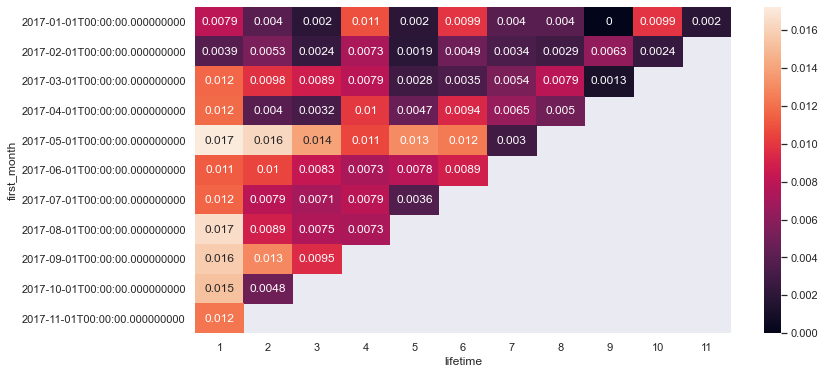

In [130]:
sns.set(rc={'figure.figsize':(12,6)} )
sns.heatmap(purchases, annot=True)

### Ответ:
Исходя из построенного графика можно сделать вывод, что чаще всего покупатели из когорты `"2017-05-01"` делали повторный заказ в 3-ем месяце 


### Задание 6.
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров (23 балла)

In [131]:
# Создаю таблицу, в которую включены уникальные ID клиента с самой поздней датой его заказа
rfm_data = delivered_orders_all.groupby('customer_unique_id', as_index=False).agg({'order_purchase_timestamp':'max'})

In [132]:
# Создаю таблицу, в которую включены уникальные ID клиента и количество его заказов
frequency_df = delivered_orders_all.groupby('customer_unique_id', as_index=False).agg({'order_id':'count'}).rename(columns={'order_id':'orders'})

In [133]:
# Создаю таблицу, в которую включены уникальные ID клиента и общая сумма его заказов
monetary_df = delivered_orders_all.groupby('customer_unique_id', as_index=False).agg({'price':'sum'})

In [134]:
# Объединяю 3 созданные таблицы по полю ID клиента
rfm_data = rfm_data.merge(frequency_df, on=['customer_unique_id']).merge(monetary_df, on=['customer_unique_id'])

In [135]:
# маскимальная дата в общем датафрейме. Принимаем, что база актуальная и нынешняя дата - это следующая за максимальной в таблице
rfm_data['today_day'] = cust_orders.order_purchase_timestamp.max()+ timedelta(days=1)

In [136]:
# Вычисляем для каждого клиента количество дней с последнего заказа
rfm_data['recency'] = rfm_data['today_day'] - rfm_data['order_purchase_timestamp']

In [137]:
# Высчитываем показатель recency. Делим все данные о разницу между датой заказа и нынешней датой на 4 блока. 
 # Чем больше прошло времени, тем меньшая баллов присваивается
rfm_data['r'] = 4 - pd.qcut(rfm_data['recency'], 4, labels=False)

In [138]:
# Так как в таблице слишком много покупателей, которые сделали заказ только 1 или 2 раза, с помощью qcut равно разделит не получается.
 # Функция присваивает от 1 до 4 баллов в зависимости от количества заказов 
def get_f(x):
    if x == 1:
        return 1
    if x ==2:
        return 2
    if x ==3:
        return 3
    return 4 

In [139]:
# Применяем функцию к столбцу с количеством заказов. Вычисляем показатель frequency
rfm_data['f'] = rfm_data.orders.apply(get_f)

In [140]:
# Вычисляем показатель monetary. Чем больше денег потрачено, тем больше балл присваеваем
rfm_data['m'] = pd.qcut(rfm_data['price'], 4, labels=False)+1

In [141]:
# Считаем показатель rfm. Нормализуем его, чтобы он был в рамках 1 до 4
rfm_data['rfm'] = (rfm_data['r'] + rfm_data['f'] + rfm_data['m'])/ 3

In [142]:
rfm_data

,customer_unique_id,order_purchase_timestamp,orders,price,today_day,recency,r,f,m,rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,2018-10-18 17:30:18,161 days 06:33:51,4,1,3,2.666667
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,2018-10-18 17:30:18,164 days 06:18:51,4,1,1,2.000000
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,2018-10-18 17:30:18,586 days 20:25:15,1,1,2,1.333333
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,2018-10-18 17:30:18,370 days 21:00:37,2,1,1,1.333333
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,2018-10-18 17:30:18,337 days 21:44:36,2,1,4,2.333333
...,...,...,...,...,...,...,...,...,...,...
96005,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2,1570.00,2018-10-18 17:30:18,496 days 20:29:42,1,2,4,2.333333
96006,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1,64.89,2018-10-18 17:30:18,311 days 21:22:22,2,1,2,1.666667
96007,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,1,89.90,2018-10-18 17:30:18,618 days 01:41:02,1,1,3,1.666667
96008,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,1,115.00,2018-10-18 17:30:18,169 days 02:12:37,3,1,3,2.333333


Поделим всех клиентов на группы на основании полученных данных RFM

In [143]:
# Функция присваивает название статуса клиента в зависимости от его значения RFM
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'

In [144]:
# Вычисяем RFM путем сложения показателей
rfm_data['RFM_Score'] = (rfm_data['r'] + rfm_data['f'] + rfm_data['m'])

In [145]:
# Применяем функцию для присвоения каждому клиенту статуса
rfm_data['segment'] = rfm_data.apply(rfm_level,axis=1)

In [146]:
rfm_data

,customer_unique_id,order_purchase_timestamp,orders,price,today_day,recency,r,f,m,rfm,RFM_Score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,2018-10-18 17:30:18,161 days 06:33:51,4,1,3,2.666667,8,Champions
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,2018-10-18 17:30:18,164 days 06:18:51,4,1,1,2.000000,6,Potential
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,2018-10-18 17:30:18,586 days 20:25:15,1,1,2,1.333333,4,Needs Attention
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,2018-10-18 17:30:18,370 days 21:00:37,2,1,1,1.333333,4,Needs Attention
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,2018-10-18 17:30:18,337 days 21:44:36,2,1,4,2.333333,7,Loyal
...,...,...,...,...,...,...,...,...,...,...,...,...
96005,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2,1570.00,2018-10-18 17:30:18,496 days 20:29:42,1,2,4,2.333333,7,Loyal
96006,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1,64.89,2018-10-18 17:30:18,311 days 21:22:22,2,1,2,1.666667,5,Promising
96007,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,1,89.90,2018-10-18 17:30:18,618 days 01:41:02,1,1,3,1.666667,5,Promising
96008,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,1,115.00,2018-10-18 17:30:18,169 days 02:12:37,3,1,3,2.333333,7,Loyal


In [194]:
# Рассчитать средние значения для каждого сегмента и вернуть размер каждого сегмента 
rfm_level_agg = rfm_data.groupby('segment').agg({
    'r': 'mean',
    'f': 'mean',
    'm': ['mean', 'count']
}).round(1)

print(rfm_level_agg)

                      r    f    m       
                   mean mean mean  count
segment                                 
Can't Loose Them    3.7  1.9  3.9   9242
Champions           3.3  1.3  3.4  12387
Loyal               2.9  1.1  2.9  17746
Needs Attention     1.5  1.0  1.5  11398
Potential           2.5  1.1  2.4  22194
Promising           2.0  1.0  1.9  17083
Require Activation  1.0  1.0  1.0   5960


In [204]:
rfm_level_agg.head(3).m['count'].sum()*100/rfm_level_agg.m['count'].sum()

41.01135298406416

Отсюда мы видим, что 41 % наших клиентов находится на верхних уровнях RFM. Магазин должен делать что-то правильно, чтобы поддерживать свою лояльность!

Остальные 59 % покупателей требуют некоторой работы. 

- `Potential` — высокий потенциал для входа в наши сегменты постоянных клиентов, нужно привлечь их для продолжения покупок
- `Promising` — показывают, что клиенты не так давно делали заказ, но он был лишь один. 
- `Needs Attention` — довольно давно сделал первоначальную покупку, но с тех пор ничего не заказывал. 
- `Require Activation` — худшие показатели нашей модели RFM. 

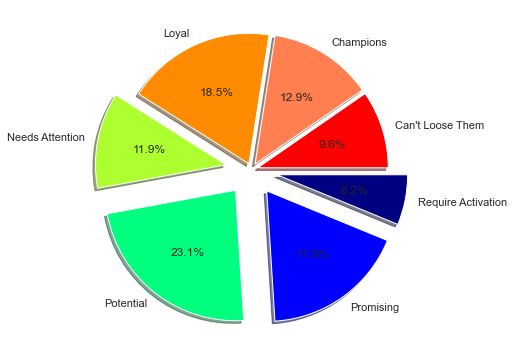

In [191]:
if __name__ == '__main__':
    # Данные для построения графика
    labels=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation']
    # Цвета для секторов
    colors = ["red", "coral", "darkorange", "greenyellow", "springgreen", "blue", "navy"]
    
    explode = (0.05, 0.05, 0.05, 0.2, 0.2, 0.2, 0.2) 
    # Нарисовать круговой график
    plt.pie(rfm_level_agg.Count, explode = explode, colors=colors, labels=labels, shadow=True, autopct='%1.1f%%')

    plt.show()